# Take a look at specific samples before and after CellBender

Create a figure for the supplement (probably) that shows one of UMAP, dotplot (genes), dotplot (programs), violins (gene), violins (program), that demonstrates the effects of cleaning up data with CellBender.

Stephen Fleming
20200914

In [1]:
# set this for a sample of interest

sample = '02-P005175-S053-R01'  # a great example

In [2]:
import pandas as pd
import numpy as np

import scanpy as sc
import harmony
from harmony import harmonize

import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sc.__version__

'1.6.1'

## Grab data

In [4]:
from typing import List
import anndata
import gc


def get_data(sample: str,
             n_umi_cutoff: int = 0,
             n_gene_cutoff: int = 0,
             cellranger_directory: str = '/home/jupyter-user/data/cellranger/',
             cellbender_directory: str = '/home/jupyter-user/data/cellbender_v2/') -> anndata.AnnData:
    """Combine CellRanger and CellBender data into one anndata object using layers."""
        
    print(sample)

    # find file
    filename = glob.glob(os.path.join(cellranger_directory, sample + '*.h5'))

    if len(filename) == 0:
        print(f'Skipping sample {sample}... it is assumed it failed QC.')
        return

    assert len(filename) == 1, f'file glob was {filename}'
    filename = filename[0]

    # load data
    ad_tmp = sc.read_10x_h5(filename)
    ad_tmp.var_names_make_unique()
    ad_tmp.layers['cellranger'] = ad_tmp.X.copy()
    ad_tmp.obs['sample'] = sample

    # filter cells
    sc.pp.filter_cells(ad_tmp, 
                       min_counts=n_umi_cutoff, 
                       inplace=True)
    sc.pp.filter_cells(ad_tmp,  
                       min_genes=n_gene_cutoff, 
                       inplace=True)
    print(ad_tmp.shape)

    # cellbender data
    filename_cb = glob.glob(os.path.join(cellbender_directory, sample + '*.h5'))
    
    if len(filename_cb) == 0:
        print(f'Cannot find {sample} in CellBender folder... did it fail?')
        return

    assert len(filename_cb) == 1, f'file glob was {filename_cb}'
    filename_cb = filename_cb[0]
    
    ad_tmp_cb = sc.read_10x_h5(filename_cb)
    ad_tmp_cb.var_names_make_unique()
    
    # add to cellranger dataset
    ad_tmp = ad_tmp[ad_tmp_cb.obs.index]
    ad_tmp.layers['cellbender'] = ad_tmp_cb.X.copy()

    # rename cell barcodes
    ad_tmp.obs.index = sample + '-' + ad_tmp.obs.index
    ad_tmp.obs.index = [s[:-2] for s in ad_tmp.obs.index]

    return ad_tmp


def get_pegasus_data(sample: str,
                     directory: str = '/home/jupyter-user/analysis/pegasus') -> anndata.AnnData:
    """Grab anndata object processed by pegasus."""
        
    print(sample)

    # find file
    print(os.path.join(directory, sample + '*.h5ad'))
    filename = glob.glob(os.path.join(directory, sample + '*.h5ad'))

    if len(filename) == 0:
        print(f'Skipping sample {sample}... it is assumed it failed QC.')
        return

    assert len(filename) == 1, f'file glob was {filename}'
    filename = filename[0]

    # load data
    ad_tmp = sc.read_h5ad(filename)
    print(ad_tmp.shape)

    return ad_tmp


def add_pegasus_annotations_to_adata(adata: anndata.AnnData, 
                                     adata_pegasus: anndata.AnnData, 
                                     obs_startswith: str = 'Lung',
                                     prefix: str= ''):
    """Add annotations from pegasus adata object to adata, with UMAP and leiden_labels."""
    
    # add the gene score annotations to adata
    for gene_set in [c for c in adata_pegasus.obs.columns if c.startswith(obs_startswith)]:
        adata.obs[prefix + gene_set] = adata_pegasus.obs[gene_set]
        
    # subset to the cells in the pegasus dataset
    adata = adata[adata_pegasus.obs.index]

    # add pegasus cell annotations
    adata.obsm[f'X_{prefix}umap'] = adata_pegasus.obsm['X_umap']
    adata.obs[f'{prefix}leiden_labels'] = adata_pegasus.obs['leiden_labels']
    
    return adata

In [5]:
adata = get_data(sample=sample, n_umi_cutoff=1)

02-P005175-S053-R01


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(873511, 33567)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
adata

AnnData object with n_obs × n_vars = 14107 × 33567
    obs: 'sample', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'cellranger', 'cellbender'

In [7]:
adata.layers['cellranger']

<14107x33567 sparse matrix of type '<class 'numpy.float32'>'
	with 11824017 stored elements in Compressed Sparse Row format>

In [8]:
adata.layers['cellbender']

<14107x33567 sparse matrix of type '<class 'numpy.float32'>'
	with 10283344 stored elements in Compressed Sparse Row format>

In [9]:
adata_pegasus = get_pegasus_data(sample=sample)

02-P005175-S053-R01
/home/jupyter-user/analysis/pegasus/02-P005175-S053-R01*.h5ad
(8292, 25208)


In [10]:
adata = add_pegasus_annotations_to_adata(adata, adata_pegasus)

In [11]:
adata

AnnData object with n_obs × n_vars = 8292 × 33567
    obs: 'sample', 'n_counts', 'n_genes', 'LungMuus_Basal', 'LungMuus_Secretory', 'LungMuus_Ciliated', 'LungMuus_Tuft.like', 'LungMuus_Ionocytes', 'LungMuus_AT1', 'LungMuus_AT2', 'LungMuus_Mesothelium', 'LungMuus_Endothelial', 'LungMuus_Fibroblast', 'LungMuus_Pericytes', 'LungMuus_SmoothMuscle', 'LungMuus_Myeloid', 'LungMuus_B.cells', 'LungMuus_Mast', 'LungMuus_T.NK.cells', 'LungMuus_immune', 'LungAtlasBraga_Basal', 'LungAtlasBraga_Ciliated', 'LungAtlasBraga_Club', 'LungAtlasBraga_Goblet1', 'LungAtlasBraga_Goblet2', 'LungAtlasBraga_Ionocyte', 'LungAtlasBraga_AT2', 'LungAtlasBraga_AT1', 'LungAtlasBraga_Macrophage', 'LungAtlasBraga_Dendritic_cells', 'LungAtlasBraga_Fibroblast', 'LungAtlasBraga_Smooth_muscle', 'leiden_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'X_umap'
    layers: 'cellranger', 'cellbender'

## UMAP

... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


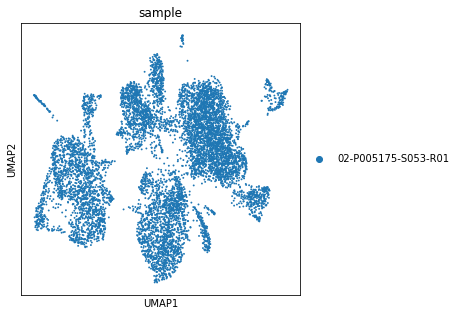

In [12]:
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 5))
sc.pl.embedding(adata, basis='umap', color='sample', ax=plt.gca())

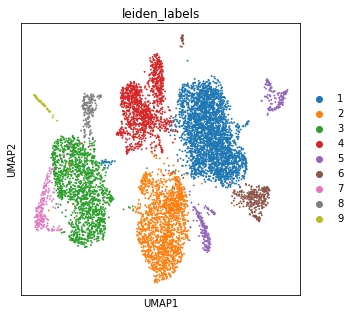

In [13]:
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 5))
sc.pl.embedding(adata, basis='umap', color='leiden_labels', ax=plt.gca())

In [14]:
adata.var['gene_name'] = [g[14:] for g in adata.var.index]

adata.var.index = adata.var['gene_name']

In [15]:
adata.var.head()

gene_ids    feature_types         genome  \
gene_name                                                                    
MIR1302-2HG  GRCh38premrna_ENSG00000243485  Gene Expression  GRCh38premrna   
FAM138A      GRCh38premrna_ENSG00000237613  Gene Expression  GRCh38premrna   
OR4F5        GRCh38premrna_ENSG00000186092  Gene Expression  GRCh38premrna   
AL627309.1   GRCh38premrna_ENSG00000238009  Gene Expression  GRCh38premrna   
AL627309.3   GRCh38premrna_ENSG00000239945  Gene Expression  GRCh38premrna   

               gene_name  
gene_name                 
MIR1302-2HG  MIR1302-2HG  
FAM138A          FAM138A  
OR4F5              OR4F5  
AL627309.1    AL627309.1  
AL627309.3    AL627309.3

## UMAP

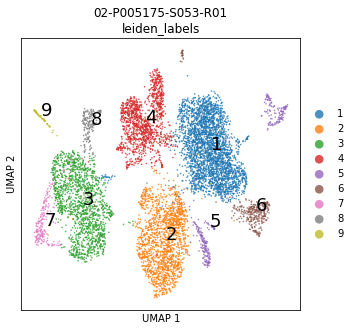

In [21]:
# umap

# show clustering with numbers

# key = 'leiden0.5'
key = 'leiden_labels'

plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 5))
sc.pl.scatter(adata, basis='umap', color=key, 
              ax=plt.gca(), size=10, alpha=0.8, show=False)

df = pd.DataFrame(adata.obsm['X_umap'])
df['cluster'] = adata.obs[key].values
mean_pos = df.groupby('cluster').median()

for c in mean_pos.index:
    
    plt.gca().text(mean_pos.loc[c][0] + 0.1, 
                   mean_pos.loc[c][1] + 0.01, 
                   c.split(':')[0], 
                   fontsize=18, color='black')

plt.title(f'{sample}\n{key}')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()

In [22]:
# cells per cluster

adata.obs[key].value_counts()

1    2888
2    1621
3    1469
4    1229
5     329
6     328
7     199
8     173
9      56
Name: leiden_labels, dtype: int64

## Marker genes via simple Wilcoxon test

In [23]:
# cursory marker genes via wilcoxon test

sc.tl.rank_genes_groups(adata, groupby=key, method='wilcoxon',
                        key_added='rank_genes_groups_' + key)  # method='t-test_overestim_var')

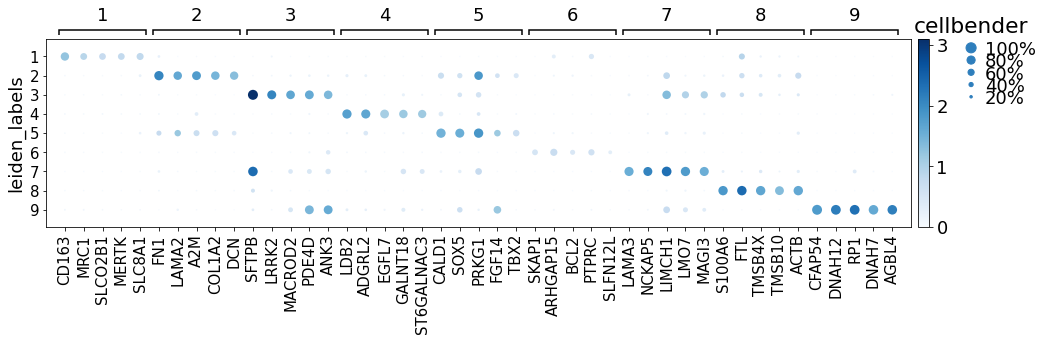

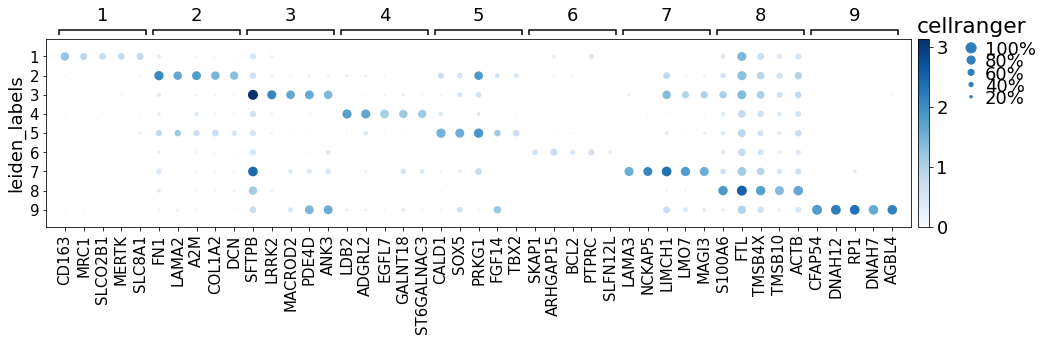

In [24]:
# plot marker genes for the outlier "clusters"
n = 5

cluster_key = key

marker_key = 'rank_genes_groups_' + cluster_key

marker_genes = np.array(adata.uns[marker_key]['names'][:(n + 10)].tolist(), 
                        dtype=str).transpose()
unique_markers = {}
for k in range(marker_genes.shape[0]):
    i = 0
    genes = []
    for g in marker_genes[k, :]:
        if (i < n 
            and g not in unique_markers 
            and g != 'nan'
            and g != 'MALAT1'
            and g not in [a for it in list(unique_markers.values()) for a in it]):
            genes.append(g)
            i += 1
    unique_markers.update({str(k + 1): genes})

plt.rcParams.update({'font.size': 18})

sc.pl.dotplot(adata, 
              var_names=unique_markers, 
              layer='cellbender',
              groupby=cluster_key,
              log=True,
#               standard_scale='var',
              color_map='Blues',
              smallest_dot=2,
              show=False)
plt.title('cellbender')
plt.show()

sc.pl.dotplot(adata, 
              var_names=unique_markers, 
              layer='cellranger',
              groupby=cluster_key,
              log=True,
#               standard_scale='var',
              color_map='Blues',
              smallest_dot=2,
              show=False)
plt.title('cellranger')
plt.show()

## Specific dotplots

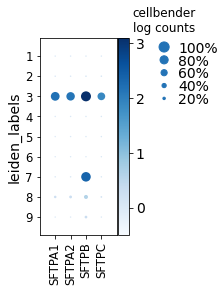

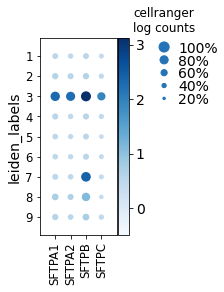

In [26]:
plt.rcParams.update({'font.size': 14})

# vmax = None
# cmap = 'PuRd'

vmin = -0.5
vmax = None
cmap = 'Blues'

sc.pl.dotplot(adata, 
              var_names=['SFTPA1', 'SFTPA2', 'SFTPB', 'SFTPC'], 
              layer='cellbender',
              groupby='leiden_labels',
              log=True,
#               standard_scale='var',
              color_map=cmap,
              vmin=vmin,
              vmax=vmax,
              smallest_dot=2,
              show=False)
plt.title('cellbender\nlog counts' + ('\n(values truncated)' 
                                      if vmax is not None else ''), fontsize=12)
plt.gcf().savefig('/home/jupyter-user/analysis/figures/surfactant_dotplot_cellbender.pdf', 
                  bbox_inches='tight')
plt.show()

sc.pl.dotplot(adata, 
              var_names=['SFTPA1', 'SFTPA2', 'SFTPB', 'SFTPC'], 
              layer='cellranger',
              groupby='leiden_labels',
              log=True,
#               standard_scale='var',
              color_map=cmap,
              vmin=vmin,
              vmax=vmax,
              smallest_dot=2,
              show=False)
plt.title('cellranger\nlog counts' + ('\n(values truncated)' 
                                      if vmax is not None else ''), fontsize=12)
plt.gcf().savefig('/home/jupyter-user/analysis/figures/surfactant_dotplot_cellranger.pdf', 
                  bbox_inches='tight')
plt.show()

## A few violin plots

In [27]:
adata.var_names[adata.var_names.str.startswith('SFTP')]

Index(['SFTPB', 'SFTPC', 'SFTPA2', 'SFTPA1', 'SFTPD', 'SFTPD-AS1'], dtype='object', name='gene_name')

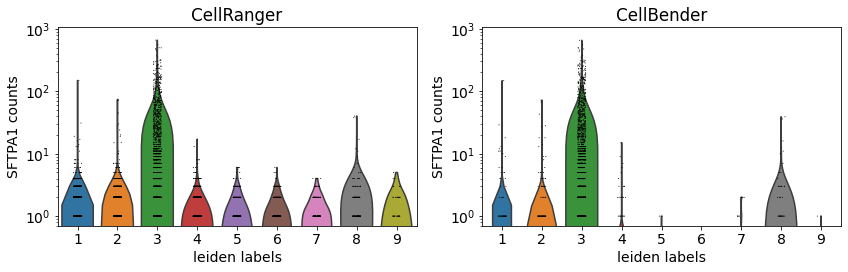

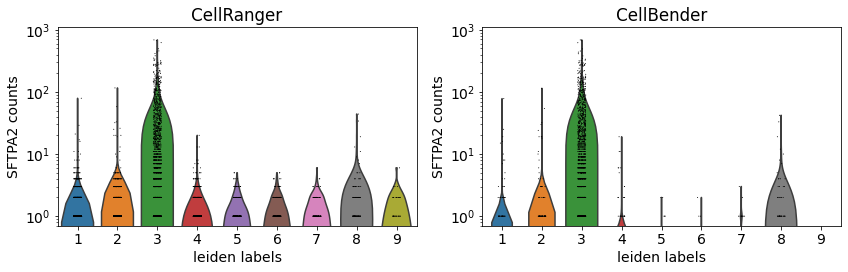

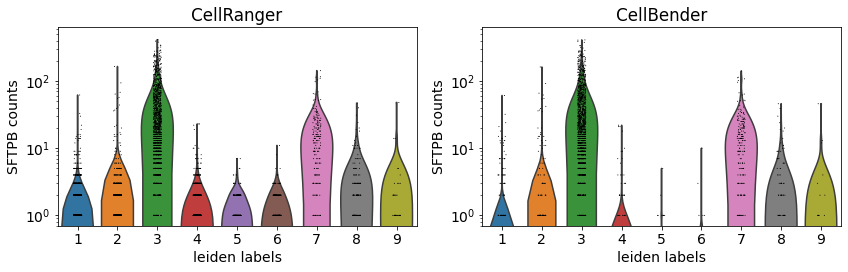

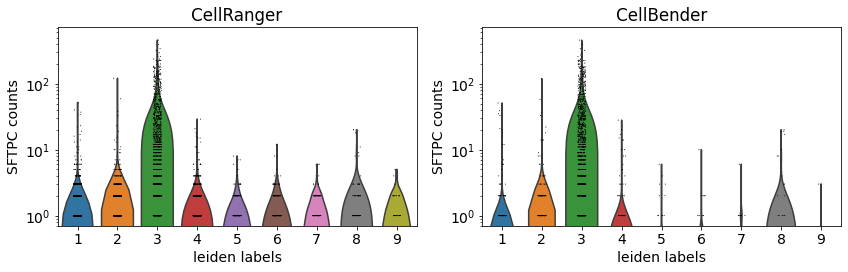

In [28]:
plt.rcParams.update({'font.size': 14})

for g in ['SFTPA1', 'SFTPA2', 'SFTPB', 'SFTPC']:
    
    fig = plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sc.pl.violin(adata, keys=g, ax=plt.gca(),
                 groupby=cluster_key, log=True, bw=0.5, layer='cellranger', show=False)
    plt.ylabel(f'{g} counts')
    plt.title('CellRanger')
    plt.ylim(bottom=7e-1)
    ytop = plt.gca().get_ylim()[-1]
    
    plt.subplot(1, 2, 2)
    sc.pl.violin(adata, keys=g, ax=plt.gca(),
                 groupby=cluster_key, log=True, bw=0.5, layer='cellbender', show=False)
    plt.ylabel(f'{g} counts')
    plt.title('CellBender')
    plt.ylim([7e-1, ytop])
    
    plt.tight_layout()
    
    fig.savefig(f'/home/jupyter-user/analysis/figures/{g}_violin.pdf', bbox_inches='tight')
    
    plt.show()

## Genes overlaid on UMAPs

In [29]:
def plot_umap(adata, color, layer, colorbar_label, ax, **kwargs):
    x = adata.obsm['X_umap'][:, 0]
    y = adata.obsm['X_umap'][:, 1]
    if color in adata.var_names:
        c = np.array(adata.layers[layer][:, adata.var_names == color].todense()).squeeze()
    else:
        c = adata.obs[color].values
    order = np.argsort(c)
    im = ax.scatter(x=x[order], y=y[order], c=c[order], **kwargs)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    cbar = plt.gcf().colorbar(im, aspect=30)
    cbar.ax.set_ylabel(colorbar_label, rotation=270, labelpad=15)

## Extended Data Figure 1f

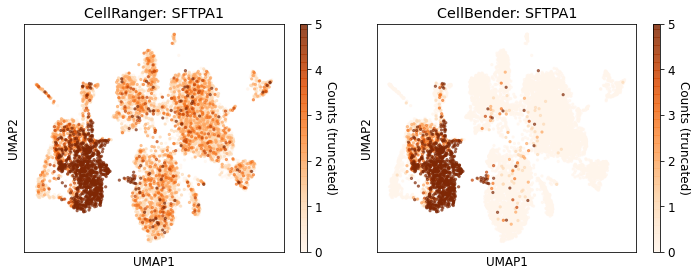

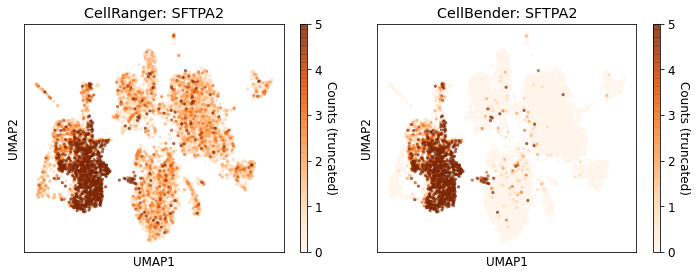

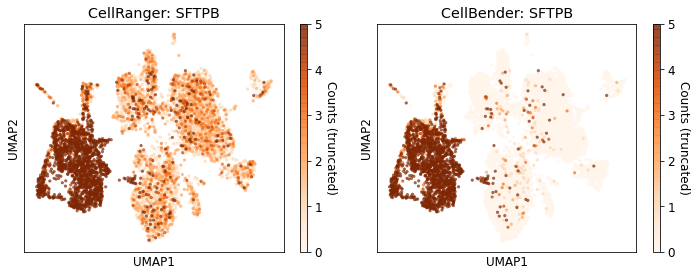

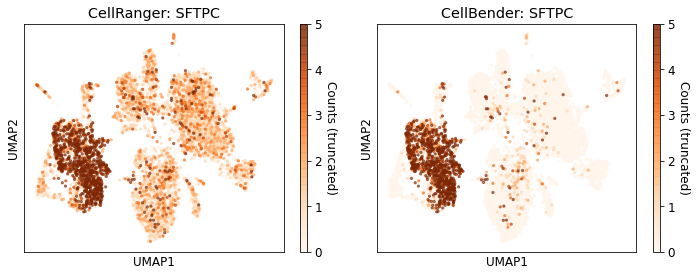

In [30]:
plt.rcParams.update({'font.size': 12})

vmax = 5

for g in ['SFTPA1', 'SFTPA2', 'SFTPB', 'SFTPC']:
    
    fig = plt.figure(figsize=(10, 4))
    
    ax = plt.subplot(1, 2, 1)
    plot_umap(adata, color=g, layer='cellranger', ax=ax, 
              cmap='Oranges', colorbar_label='Counts' + (' (truncated)' if vmax is not None else ''), 
              s=5, vmax=vmax, alpha=0.6, rasterized=True)
    plt.title('CellRanger: ' + g)
    
    ax = plt.subplot(1, 2, 2)
    plot_umap(adata, color=g, layer='cellbender', ax=ax, 
              cmap='Oranges', colorbar_label='Counts' + (' (truncated)' if vmax is not None else ''), 
              s=5, vmax=vmax, alpha=0.6, rasterized=True)
    plt.title('CellBender: ' + g)
    
    plt.tight_layout()
    
    fig.savefig(f'/home/jupyter-user/analysis/figures/{g}_umap.pdf', bbox_inches='tight')
    
    plt.show()

## Gene sets overlaid on UMAPs

Get the gene set score information: computed previously by Pegasus pipeline.

In [31]:
adata_pegasus_raw = get_pegasus_data(sample=sample, directory='/home/jupyter-user/analysis/pegasus_raw')

# subset to adata barcodes
adata_pegasus_raw = adata_pegasus_raw[[bc in adata.obs.index for bc in adata_pegasus_raw.obs.index]]

02-P005175-S053-R01
/home/jupyter-user/analysis/pegasus_raw/02-P005175-S053-R01*.h5ad
(10687, 26345)


/home/jupyter-user/.local/lib/python3.7/site-packages/anndata/compat/__init__.py:194: FutureWarning: During AnnData slicing, found matrix at .uns['W_pca'] that happens to be dimensioned at n_obs×n_obs (10687×10687).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,


In [32]:
# add them to adata

adata = add_pegasus_annotations_to_adata(adata=adata, 
                                         adata_pegasus=adata_pegasus_raw,
                                         obs_startswith='Lung', 
                                         prefix='Raw_')

In [33]:
adata

AnnData object with n_obs × n_vars = 8288 × 33567
    obs: 'sample', 'n_counts', 'n_genes', 'LungMuus_Basal', 'LungMuus_Secretory', 'LungMuus_Ciliated', 'LungMuus_Tuft.like', 'LungMuus_Ionocytes', 'LungMuus_AT1', 'LungMuus_AT2', 'LungMuus_Mesothelium', 'LungMuus_Endothelial', 'LungMuus_Fibroblast', 'LungMuus_Pericytes', 'LungMuus_SmoothMuscle', 'LungMuus_Myeloid', 'LungMuus_B.cells', 'LungMuus_Mast', 'LungMuus_T.NK.cells', 'LungMuus_immune', 'LungAtlasBraga_Basal', 'LungAtlasBraga_Ciliated', 'LungAtlasBraga_Club', 'LungAtlasBraga_Goblet1', 'LungAtlasBraga_Goblet2', 'LungAtlasBraga_Ionocyte', 'LungAtlasBraga_AT2', 'LungAtlasBraga_AT1', 'LungAtlasBraga_Macrophage', 'LungAtlasBraga_Dendritic_cells', 'LungAtlasBraga_Fibroblast', 'LungAtlasBraga_Smooth_muscle', 'leiden_labels', 'Raw_LungMuus_Basal', 'Raw_LungMuus_Secretory', 'Raw_LungMuus_Ciliated', 'Raw_LungMuus_Tuft.like', 'Raw_LungMuus_Ionocytes', 'Raw_LungMuus_Neuroendocrine', 'Raw_LungMuus_AT1', 'Raw_LungMuus_AT2', 'Raw_LungMuus_Mesoth

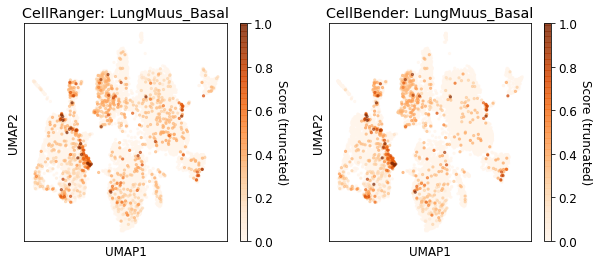

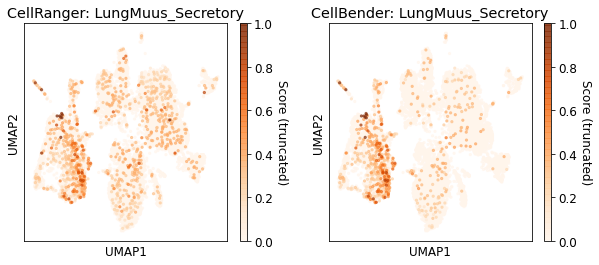

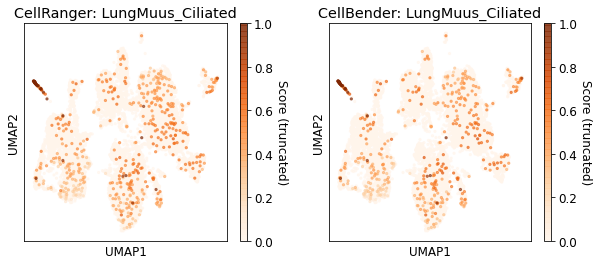

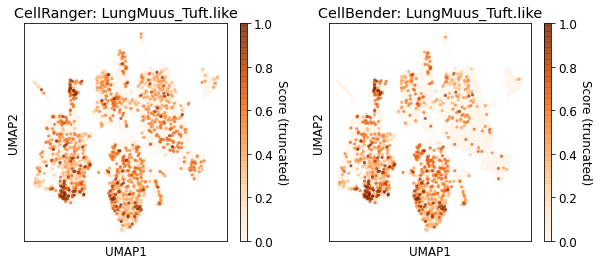

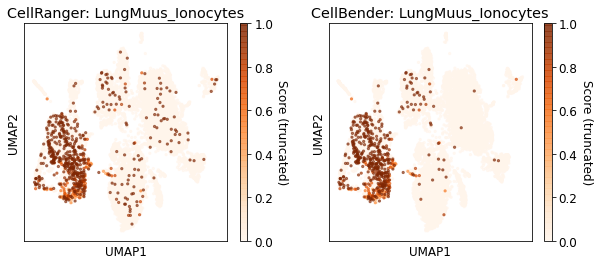

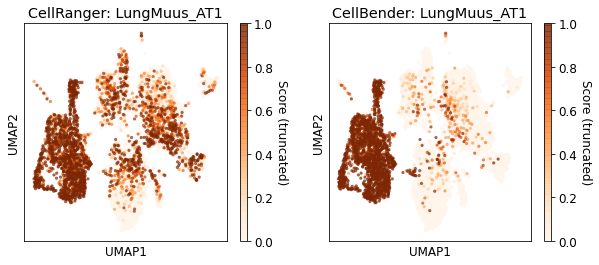

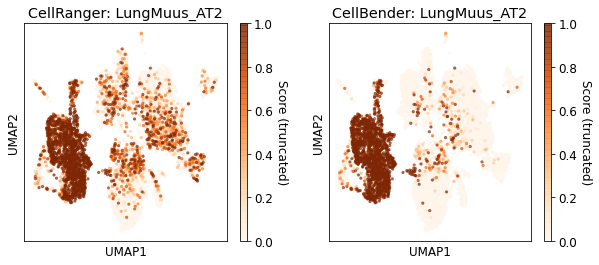

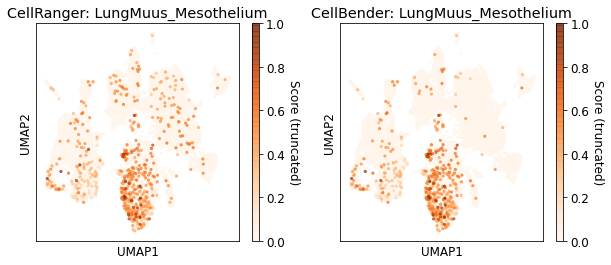

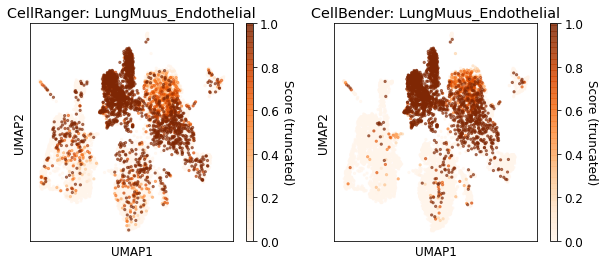

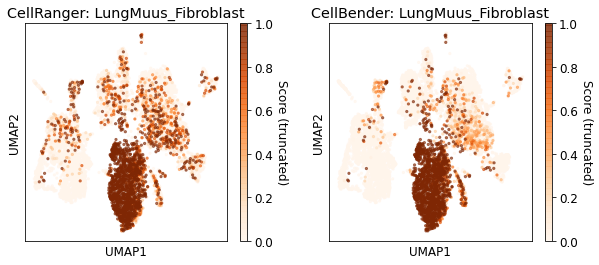

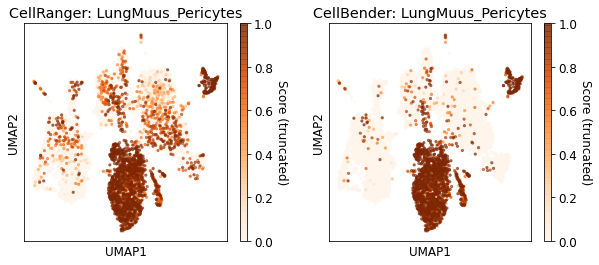

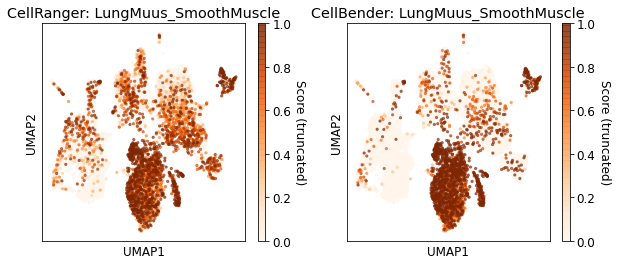

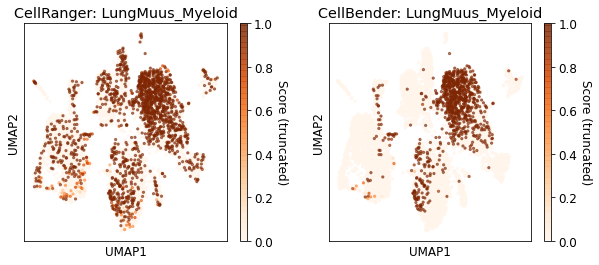

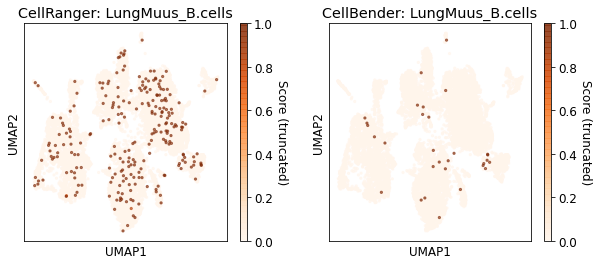

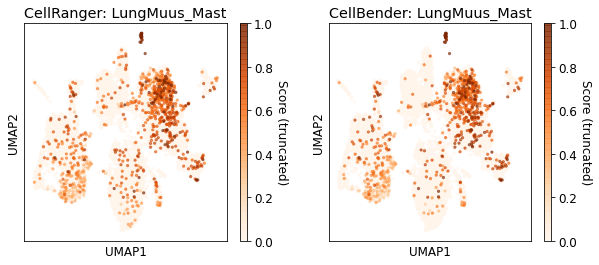

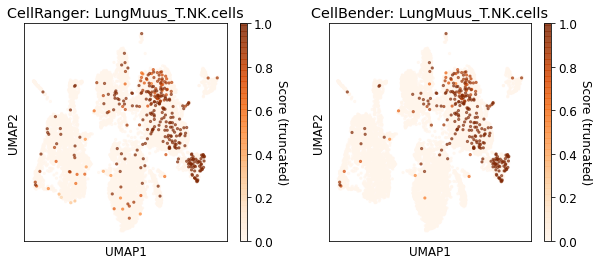

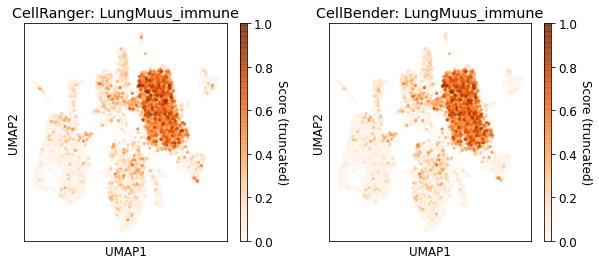

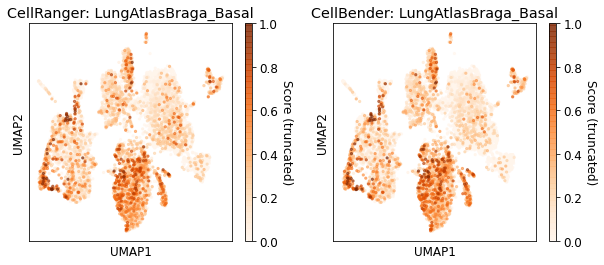

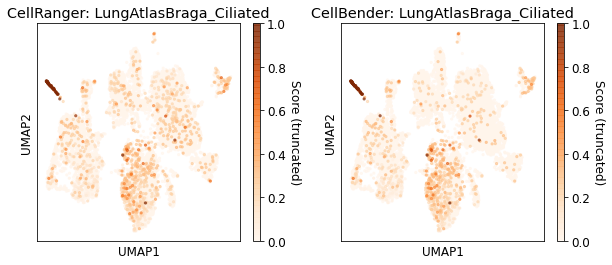

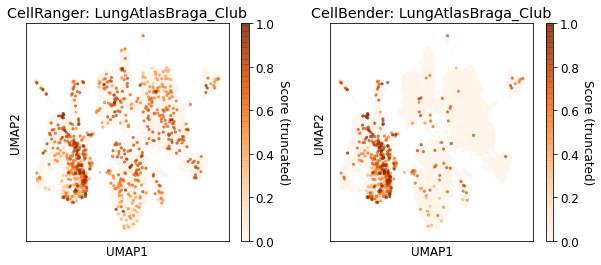

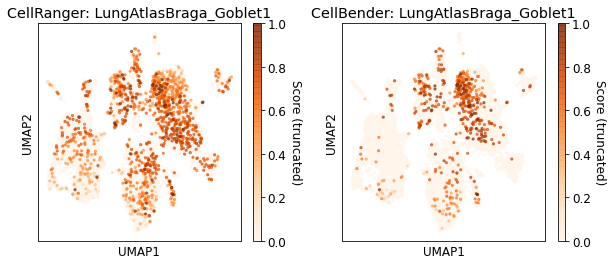

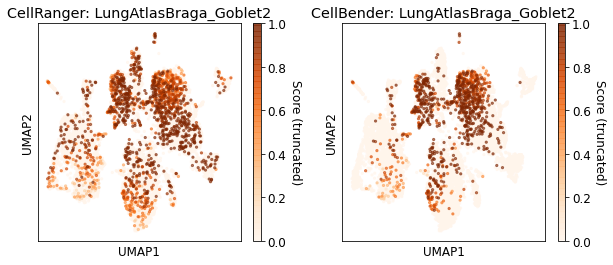

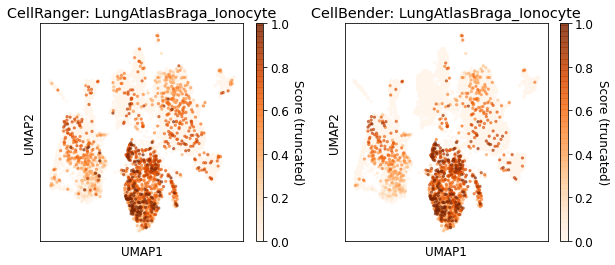

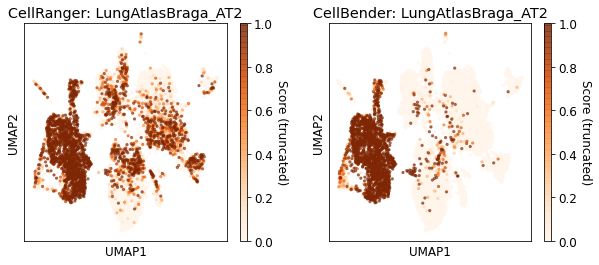

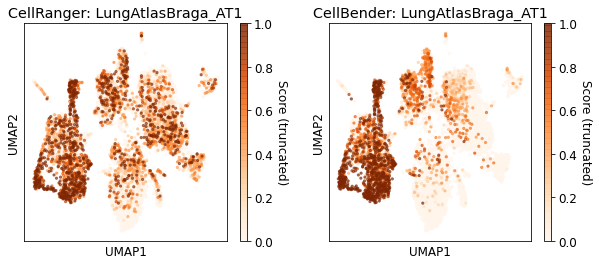

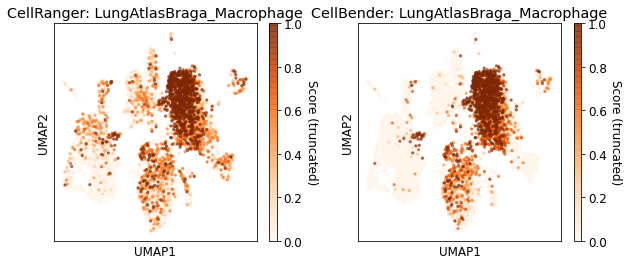

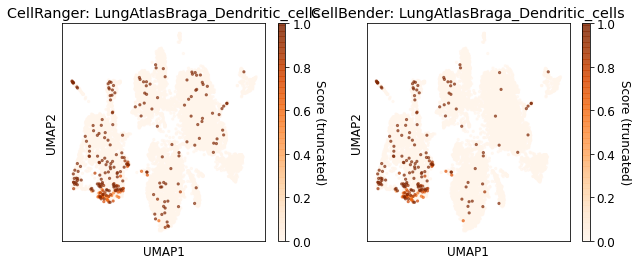

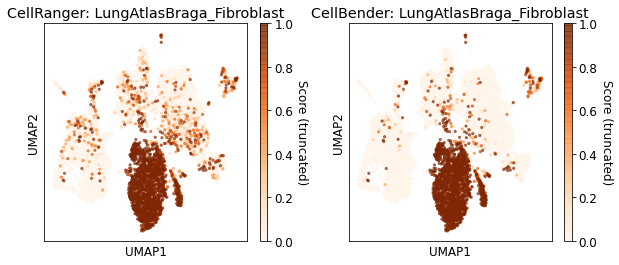

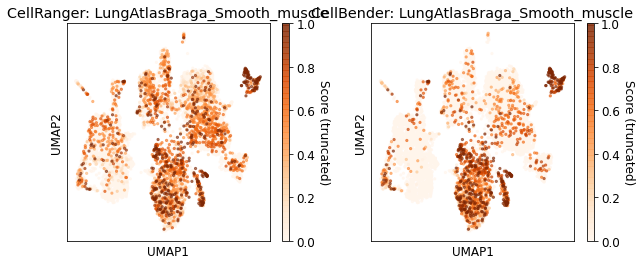

In [34]:
plt.rcParams.update({'font.size': 12})

gene_sets = adata.obs.columns[adata.obs.columns.str.startswith('Lung')]

vmin = 0
vmax = 1

for g in gene_sets:
    
    fig = plt.figure(figsize=(10, 4))
    
    ax = plt.subplot(1, 2, 1)
    plot_umap(adata, color='Raw_' + g, layer='cellranger', ax=ax, 
              cmap='Oranges', colorbar_label='Score' + (' (truncated)' if vmax is not None else ''), 
              s=5, vmin=vmin, vmax=vmax, alpha=0.6, rasterized=True)
    plt.title('CellRanger: ' + g)
    
    ax = plt.subplot(1, 2, 2)
    plot_umap(adata, color=g, layer='cellbender', ax=ax, 
              cmap='Oranges', colorbar_label='Score' + (' (truncated)' if vmax is not None else ''), 
              s=5, vmin=vmin, vmax=vmax, alpha=0.6, rasterized=True)
    plt.title('CellBender: ' + g)
    
#     plt.tight_layout()
    
    plt.show()

## Extended Data Figure 1g

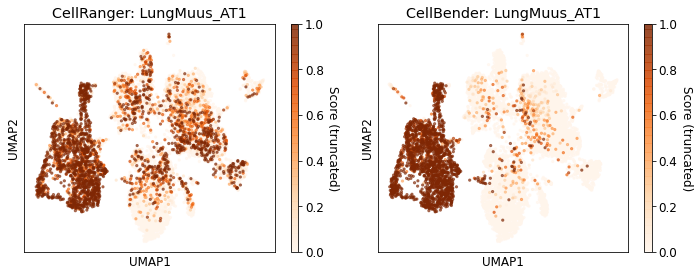

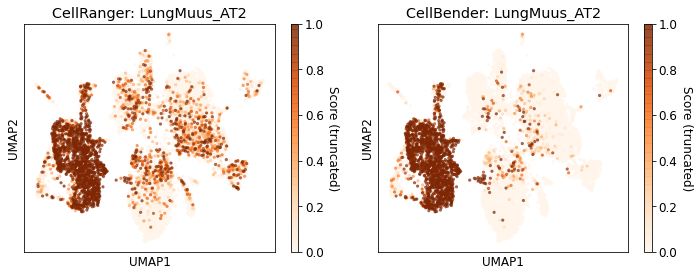

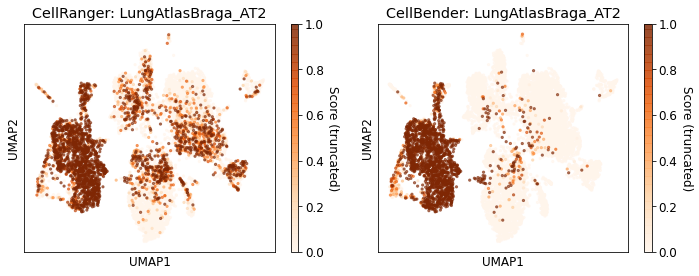

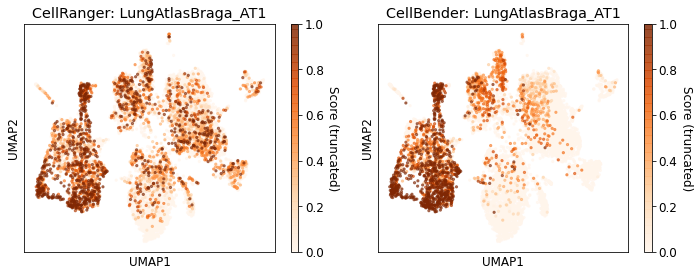

In [35]:
plt.rcParams.update({'font.size': 12})

gene_sets = adata.obs.columns[~adata.obs.columns.str.startswith('Raw_') & 
                              (adata.obs.columns.str.contains('AT1') 
                               | adata.obs.columns.str.contains('AT2'))]

vmin = 0
vmax = 1

for g in gene_sets:
    
    fig = plt.figure(figsize=(10, 4))
    
    ax = plt.subplot(1, 2, 1)
    plot_umap(adata, color='Raw_' + g, layer='cellranger', ax=ax, 
              cmap='Oranges', colorbar_label='Score' + (' (truncated)' if vmax is not None else ''), 
              s=5, vmin=vmin, vmax=vmax, alpha=0.6, rasterized=True)
    plt.title('CellRanger: ' + g)
    
    ax = plt.subplot(1, 2, 2)
    plot_umap(adata, color=g, layer='cellbender', ax=ax, 
              cmap='Oranges', colorbar_label='Score' + (' (truncated)' if vmax is not None else ''), 
              s=5, vmin=vmin, vmax=vmax, alpha=0.6, rasterized=True)
    plt.title('CellBender: ' + g)
    
    plt.tight_layout()
    fig.savefig(f'/home/jupyter-user/analysis/figures/{g}_umap.pdf', bbox_inches='tight')
    
    plt.show()

## Subtraction of each gene

In [38]:
adata

AnnData object with n_obs × n_vars = 8288 × 33567
    obs: 'sample', 'n_counts', 'n_genes', 'LungMuus_Basal', 'LungMuus_Secretory', 'LungMuus_Ciliated', 'LungMuus_Tuft.like', 'LungMuus_Ionocytes', 'LungMuus_AT1', 'LungMuus_AT2', 'LungMuus_Mesothelium', 'LungMuus_Endothelial', 'LungMuus_Fibroblast', 'LungMuus_Pericytes', 'LungMuus_SmoothMuscle', 'LungMuus_Myeloid', 'LungMuus_B.cells', 'LungMuus_Mast', 'LungMuus_T.NK.cells', 'LungMuus_immune', 'LungAtlasBraga_Basal', 'LungAtlasBraga_Ciliated', 'LungAtlasBraga_Club', 'LungAtlasBraga_Goblet1', 'LungAtlasBraga_Goblet2', 'LungAtlasBraga_Ionocyte', 'LungAtlasBraga_AT2', 'LungAtlasBraga_AT1', 'LungAtlasBraga_Macrophage', 'LungAtlasBraga_Dendritic_cells', 'LungAtlasBraga_Fibroblast', 'LungAtlasBraga_Smooth_muscle', 'leiden_labels', 'Raw_LungMuus_Basal', 'Raw_LungMuus_Secretory', 'Raw_LungMuus_Ciliated', 'Raw_LungMuus_Tuft.like', 'Raw_LungMuus_Ionocytes', 'Raw_LungMuus_Neuroendocrine', 'Raw_LungMuus_AT1', 'Raw_LungMuus_AT2', 'Raw_LungMuus_Mesoth

In [39]:
for layer in ['cellranger', 'cellbender']:

    adata.var[layer + '_count'] = np.array(adata.layers[layer].sum(axis=0)).squeeze()

In [40]:
adata.var.head()

gene_ids    feature_types         genome  \
gene_name                                                                    
MIR1302-2HG  GRCh38premrna_ENSG00000243485  Gene Expression  GRCh38premrna   
FAM138A      GRCh38premrna_ENSG00000237613  Gene Expression  GRCh38premrna   
OR4F5        GRCh38premrna_ENSG00000186092  Gene Expression  GRCh38premrna   
AL627309.1   GRCh38premrna_ENSG00000238009  Gene Expression  GRCh38premrna   
AL627309.3   GRCh38premrna_ENSG00000239945  Gene Expression  GRCh38premrna   

               gene_name  cellranger_count  cellbender_count  
gene_name                                                     
MIR1302-2HG  MIR1302-2HG               0.0               0.0  
FAM138A          FAM138A               0.0               0.0  
OR4F5              OR4F5               0.0               0.0  
AL627309.1    AL627309.1              40.0              40.0  
AL627309.3    AL627309.3               0.0               0.0

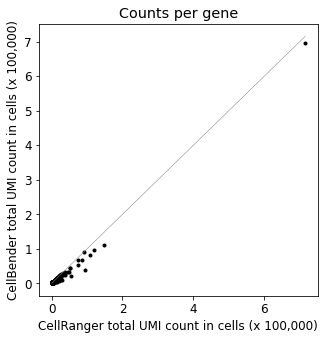

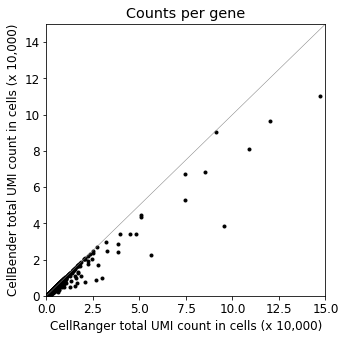

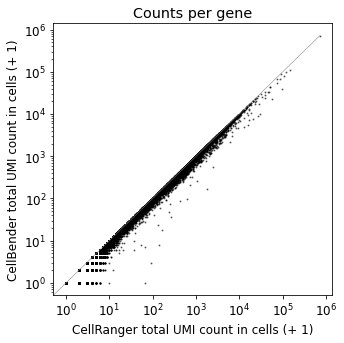

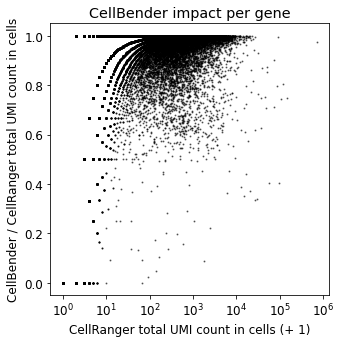

In [41]:
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] / 1e5, adata.var['cellbender_count'] / 1e5, 'k.')
plt.plot([0, adata.var['cellranger_count'].max() / 1e5], 
         [0, adata.var['cellranger_count'].max() / 1e5], color='gray', lw=0.5)
plt.xlabel('CellRanger total UMI count in cells (x 100,000)')
plt.ylabel('CellBender total UMI count in cells (x 100,000)')
plt.title('Counts per gene')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] / 1e4, adata.var['cellbender_count'] / 1e4, 'k.')
plt.plot([0, adata.var['cellranger_count'].max() / 1e4], 
         [0, adata.var['cellranger_count'].max() / 1e4], color='gray', lw=0.5)
plt.xlabel('CellRanger total UMI count in cells (x 10,000)')
plt.ylabel('CellBender total UMI count in cells (x 10,000)')
plt.xlim([0, 15])
plt.ylim([0, 15])
plt.title('Counts per gene')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] + 1, adata.var['cellbender_count'] + 1, 
         'k.', ms=2, alpha=0.5)
plt.plot([0, adata.var['cellranger_count'].max()], 
         [0, adata.var['cellranger_count'].max()], color='gray', lw=0.5, ms=2)
plt.xlabel('CellRanger total UMI count in cells (+ 1)')
plt.ylabel('CellBender total UMI count in cells (+ 1)')
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
plt.title('Counts per gene')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['cellranger_count'] + 1, 
         adata.var['cellbender_count'] / (adata.var['cellranger_count'] + 1e-3), 
         'k.', ms=2, alpha=0.5)
plt.xlabel('CellRanger total UMI count in cells (+ 1)')
plt.ylabel('CellBender / CellRanger total UMI count in cells')
plt.xscale('log')
plt.xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
plt.title('CellBender impact per gene')
plt.show()

In [42]:
adata.var['fraction_remaining'] = adata.var['cellbender_count'] / (adata.var['cellranger_count'] + 1e-3)

In [43]:
adata.var[adata.var['cellranger_count'] > 50000].sort_values(by='fraction_remaining', ascending=True).head()

gene_ids    feature_types         genome  \
gene_name                                                                  
RASGEF1B   GRCh38premrna_ENSG00000138670  Gene Expression  GRCh38premrna   
INO80D     GRCh38premrna_ENSG00000114933  Gene Expression  GRCh38premrna   
MT-ATP6    GRCh38premrna_ENSG00000198899  Gene Expression  GRCh38premrna   
MT-CO2     GRCh38premrna_ENSG00000198712  Gene Expression  GRCh38premrna   
MT-ND3     GRCh38premrna_ENSG00000198840  Gene Expression  GRCh38premrna   

          gene_name  cellranger_count  cellbender_count  fraction_remaining  
gene_name                                                                    
RASGEF1B   RASGEF1B           95229.0           38365.0            0.402871  
INO80D       INO80D           56095.0           22710.0            0.404849  
MT-ATP6     MT-ATP6           74751.0           53062.0            0.709850  
MT-CO2       MT-CO2          108959.0           81060.0            0.743950  
MT-ND3       MT-ND3          146911.0          110117.0            0.749549

In [44]:
adata.var[adata.var['cellranger_count'] > 1000].sort_values(by='fraction_remaining', ascending=True).head(10)

gene_ids    feature_types         genome  \
gene_name                                                                  
S100A9     GRCh38premrna_ENSG00000163220  Gene Expression  GRCh38premrna   
SLC30A10   GRCh38premrna_ENSG00000196660  Gene Expression  GRCh38premrna   
S100A8     GRCh38premrna_ENSG00000143546  Gene Expression  GRCh38premrna   
SLC27A6    GRCh38premrna_ENSG00000113396  Gene Expression  GRCh38premrna   
SLC26A3    GRCh38premrna_ENSG00000091138  Gene Expression  GRCh38premrna   
LINGO1     GRCh38premrna_ENSG00000169783  Gene Expression  GRCh38premrna   
UHRF2      GRCh38premrna_ENSG00000147854  Gene Expression  GRCh38premrna   
MIB1       GRCh38premrna_ENSG00000101752  Gene Expression  GRCh38premrna   
CSMD1      GRCh38premrna_ENSG00000183117  Gene Expression  GRCh38premrna   
RASGEF1B   GRCh38premrna_ENSG00000138670  Gene Expression  GRCh38premrna   

          gene_name  cellranger_count  cellbender_count  fraction_remaining  
gene_name                                                                    
S100A9       S100A9            1835.0             164.0            0.089373  
SLC30A10   SLC30A10            2448.0             540.0            0.220588  
S100A8       S100A8            1048.0             261.0            0.249046  
SLC27A6     SLC27A6           26803.0            8955.0            0.334104  
SLC26A3     SLC26A3           29687.0           10035.0            0.338027  
LINGO1       LINGO1           15482.0            5423.0            0.350278  
UHRF2         UHRF2            6061.0            2211.0            0.364791  
MIB1           MIB1           20734.0            7707.0            0.371708  
CSMD1         CSMD1           12833.0            4995.0            0.389231  
RASGEF1B   RASGEF1B           95229.0           38365.0            0.402871

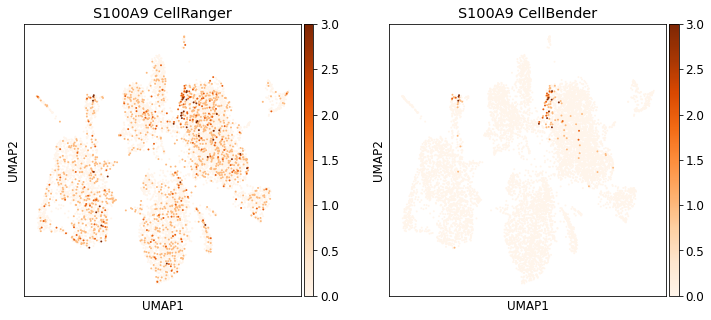

In [45]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sc.pl.embedding(adata, basis='umap', color='S100A9', 
                color_map='Oranges', layer='cellranger', ax=plt.gca(), show=False, vmax=3, size=15)
plt.title('S100A9 CellRanger')
plt.subplot(1, 2, 2)
sc.pl.embedding(adata, basis='umap', color='S100A9', 
                color_map='Oranges', layer='cellbender', ax=plt.gca(), show=False, vmax=3, size=15)
plt.title('S100A9 CellBender')
plt.show()

### Does the subtraction make sense?

In [46]:
import tables

with tables.open_file('/home/jupyter-user/data/cellbender_v2/' + sample + '_out_FPR_0.01_filtered.h5') as f:
    ambient = f.root.matrix.ambient_expression.read()

In [47]:
adata.var['ambient'] = ambient

In [48]:
adata.var.sort_values(by='ambient', ascending=False).head(32)

gene_ids    feature_types         genome  \
gene_name                                                                  
RASGEF1B   GRCh38premrna_ENSG00000138670  Gene Expression  GRCh38premrna   
MT-ND3     GRCh38premrna_ENSG00000198840  Gene Expression  GRCh38premrna   
INO80D     GRCh38premrna_ENSG00000114933  Gene Expression  GRCh38premrna   
MT-CO2     GRCh38premrna_ENSG00000198712  Gene Expression  GRCh38premrna   
MT-ND2     GRCh38premrna_ENSG00000198763  Gene Expression  GRCh38premrna   
MT-ATP6    GRCh38premrna_ENSG00000198899  Gene Expression  GRCh38premrna   
MALAT1     GRCh38premrna_ENSG00000251562  Gene Expression  GRCh38premrna   
MT-CO1     GRCh38premrna_ENSG00000198804  Gene Expression  GRCh38premrna   
SLC26A3    GRCh38premrna_ENSG00000091138  Gene Expression  GRCh38premrna   
SLC27A6    GRCh38premrna_ENSG00000113396  Gene Expression  GRCh38premrna   
MT-CO3     GRCh38premrna_ENSG00000198938  Gene Expression  GRCh38premrna   
FTL        GRCh38premrna_ENSG00000087086  Gene Expression  GRCh38premrna   
MT-ND4     GRCh38premrna_ENSG00000198886  Gene Expression  GRCh38premrna   
MIB1       GRCh38premrna_ENSG00000101752  Gene Expression  GRCh38premrna   
MT-CYB     GRCh38premrna_ENSG00000198727  Gene Expression  GRCh38premrna   
B2M        GRCh38premrna_ENSG00000166710  Gene Expression  GRCh38premrna   
LINGO1     GRCh38premrna_ENSG00000169783  Gene Expression  GRCh38premrna   
TMSB4X     GRCh38premrna_ENSG00000205542  Gene Expression  GRCh38premrna   
MT-ND1     GRCh38premrna_ENSG00000198888  Gene Expression  GRCh38premrna   
SFTPB      GRCh38premrna_ENSG00000168878  Gene Expression  GRCh38premrna   
SFTPA1     GRCh38premrna_ENSG00000122852  Gene Expression  GRCh38premrna   
FTH1       GRCh38premrna_ENSG00000167996  Gene Expression  GRCh38premrna   
SFTPA2     GRCh38premrna_ENSG00000185303  Gene Expression  GRCh38premrna   
CSMD1      GRCh38premrna_ENSG00000183117  Gene Expression  GRCh38premrna   
SFTPC      GRCh38premrna_ENSG00000168484  Gene Expression  GRCh38premrna   
ACTB       GRCh38premrna_ENSG00000075624  Gene Expression  GRCh38premrna   
MT-ND5     GRCh38premrna_ENSG00000198786  Gene Expression  GRCh38premrna   
GPX3       GRCh38premrna_ENSG00000211445  Gene Expression  GRCh38premrna   
PGC        GRCh38premrna_ENSG00000096088  Gene Expression  GRCh38premrna   
MTRNR2L12  GRCh38premrna_ENSG00000269028  Gene Expression  GRCh38premrna   
LPP        GRCh38premrna_ENSG00000145012  Gene Expression  GRCh38premrna   
S100A6     GRCh38premrna_ENSG00000197956  Gene Expression  GRCh38premrna   

           gene_name  cellranger_count  cellbender_count  fraction_remaining  \
gene_name                                                                      
RASGEF1B    RASGEF1B           95229.0           38365.0            0.402871   
MT-ND3        MT-ND3          146911.0          110117.0            0.749549   
INO80D        INO80D           56095.0           22710.0            0.404849   
MT-CO2        MT-CO2          108959.0           81060.0            0.743950   
MT-ND2        MT-ND2          120216.0           96536.0            0.803021   
MT-ATP6      MT-ATP6           74751.0           53062.0            0.709850   
MALAT1        MALAT1          714914.0          696000.0            0.973544   
MT-CO1        MT-CO1           85461.0           68127.0            0.797171   
SLC26A3      SLC26A3           29687.0           10035.0            0.338027   
SLC27A6      SLC27A6           26803.0            8955.0            0.334104   
MT-CO3        MT-CO3           48219.0           34054.0            0.706236   
FTL              FTL           38258.0           23925.0            0.625359   
MT-ND4        MT-ND4           45124.0           33903.0            0.751330   
MIB1            MIB1           20734.0            7707.0            0.371708   
MT-CYB        MT-CYB           38207.0           28577.0            0.747952   
B2M              B2M           27811.0           17259.0            0.620582   
LINGO1 

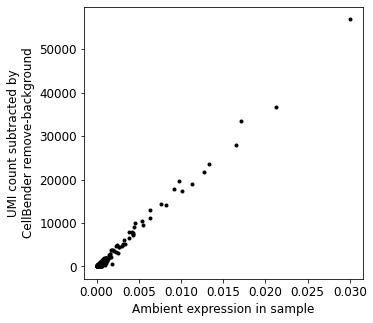

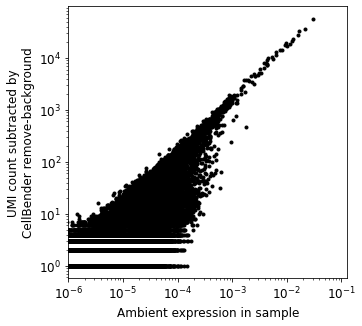

In [49]:
# ensure subtracted counts make sense

plt.figure(figsize=(5, 5))

plt.plot(adata.var['ambient'], adata.var['cellranger_count'] - adata.var['cellbender_count'], '.k')
plt.xlabel('Ambient expression in sample')
plt.ylabel('UMI count subtracted by\nCellBender remove-background')
plt.show()

plt.figure(figsize=(5, 5))

plt.plot(adata.var['ambient'], adata.var['cellranger_count'] - adata.var['cellbender_count'], '.k')
plt.xlabel('Ambient expression in sample')
plt.ylabel('UMI count subtracted by\nCellBender remove-background')
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1e-6)
plt.show()

Subtracted counts are very much in line with the ambient profile.

## Changes in UMAP caused by CellBender

UMAPs are straight from Pegasus.

I am limiting the cells to be only those called as cells by the CellBender + Pegasus pipeline.

The coloring is the same for both: the leiden_labels from the CellBender + Pegasus pipeline.

In [38]:
sc.set_figure_params(vector_friendly=True)

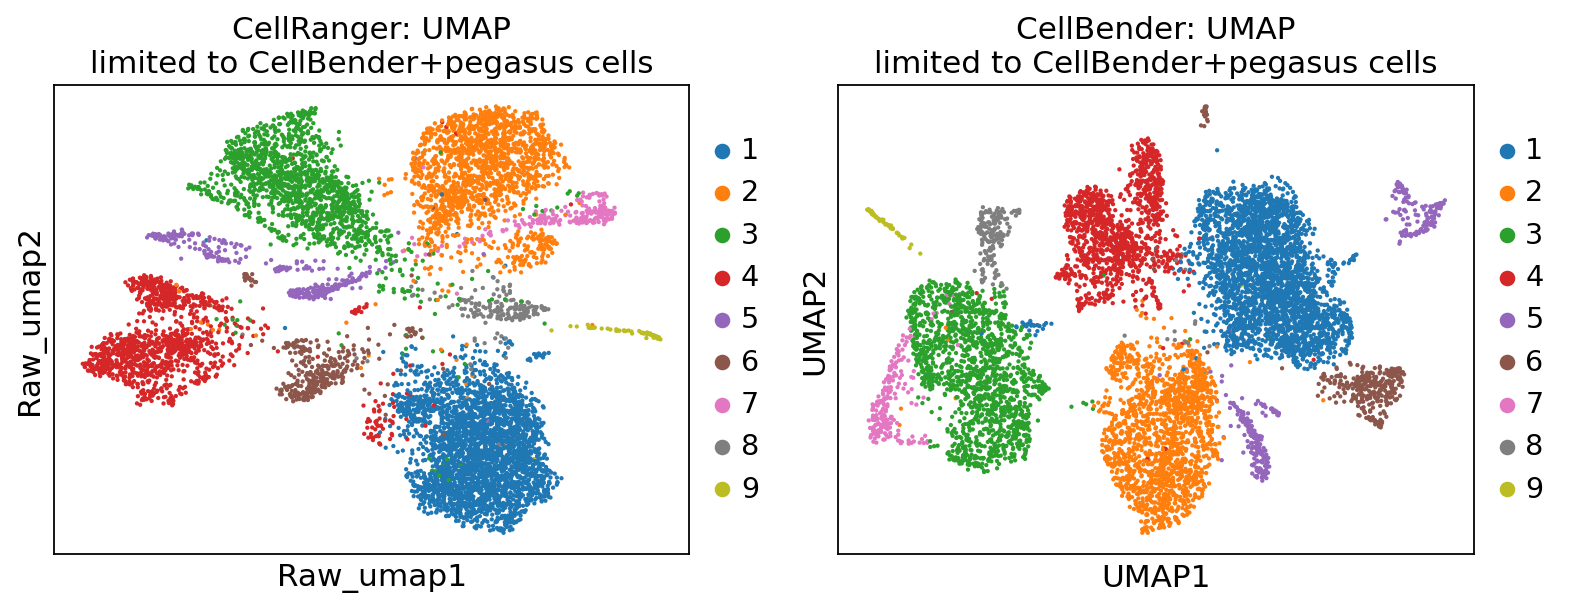

In [39]:
plt.rcParams.update({'font.size': 12})

cluster_key = 'leiden_labels'

fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sc.pl.embedding(adata, basis='Raw_umap', color=cluster_key, 
                ax=plt.gca(), color_map='Oranges', size=15, show=False)
plt.title('CellRanger: UMAP\nlimited to CellBender+pegasus cells')

plt.subplot(1, 2, 2)
sc.pl.embedding(adata, basis='umap', color=cluster_key, 
                ax=plt.gca(), color_map='Oranges', size=15, show=False)
plt.title('CellBender: UMAP\nlimited to CellBender+pegasus cells')

plt.tight_layout()

fig.savefig('/home/jupyter-user/analysis/figures/cluster_umap.pdf', bbox_inches='tight')

plt.show()

### Include cells eliminated by cellbender remove-background

In [12]:
adata_pegasus_raw = \
    get_pegasus_data(sample=sample, directory='/home/jupyter-user/analysis/pegasus_raw')

adata_pegasus_raw

02-P005175-S053-R01
/home/jupyter-user/analysis/pegasus_raw/02-P005175-S053-R01*.h5ad
(10687, 26345)


AnnData object with n_obs × n_vars = 10687 × 26345
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'JerbyMelanoma_B_CELL', 'JerbyMelanoma_CAF', 'JerbyMelanoma_ENDOTHELIAL', 'JerbyMelanoma_MACROPHAGE', 'JerbyMelanoma_MALIGNANT', 'JerbyMelanoma_NK', 'JerbyMelanoma_T_CD4', 'JerbyMelanoma_T_CD8', 'JerbyMelanoma_T_CELL', 'JerbyMelanoma_STROMA', 'JerbyMelanoma_IMMUNE', 'JerbyMelanoma_T_CD4_EXHAUSTED', 'JerbyMelanoma_T_CD4_NAIVE', 'JerbyMelanoma_T_CD4_TREG', 'JerbyMelanoma_T_CD8_CYTOTOXIC', 'JerbyMelanoma_T_CD8_EXHAUSTED', 'JerbyMelanoma_T_CD8_NAIVE', 'HTAPP_epithelial', 'HTAPP_macrophage_nuc', 'HTAPP_tcell_nuc', 'HTAPP_bcell_nuc', 'HTAPP_mast_cell', 'HTAPP_fibrocyte', 'HTAPP_astrocytes', 'HTAPP_oligodendrocytes', 'HTAPP_microglia', 'HTAPP_skeletal_muscle_myocyte_nuc', 'HTAPP_melanoma_signature', 'HTAPP_melanocyte', 'HTAPP_hepatocyte', 'HTAPP_alveolar_rhabdomyosarcoma', 'HTAPP_Ewing_sarcoma', 'HTAPP_basal_cells', 'HTAPP_secretory_cells', 'HTAPP_ciliated_cells', 'HTAPP_gobl

In [13]:
adata_pegasus_raw.obs['leiden_labels'] = adata.obs['leiden_labels']

In [14]:
adata_pegasus_raw.obs['leiden_labels'].unique()

[1, NaN, 2, 3, 4, 6, 5, 9, 8, 7]
Categories (9, object): [1, 2, 3, 4, ..., 5, 9, 8, 7]

In [15]:
pd.isnull(adata_pegasus_raw.obs['leiden_labels']).sum()

2399

In [16]:
adata_pegasus_raw.obs['leiden_labels'].cat.set_categories(
    adata_pegasus_raw.obs['leiden_labels'].cat.categories.tolist() + ['x'], inplace=True)
adata_pegasus_raw.obs['leiden_labels'][pd.isnull(adata_pegasus_raw.obs['leiden_labels'])] = 'x'
adata_pegasus_raw.obs['leiden_labels'] = adata_pegasus_raw.obs['leiden_labels'].astype('category')

## Extended Data Figure 1e

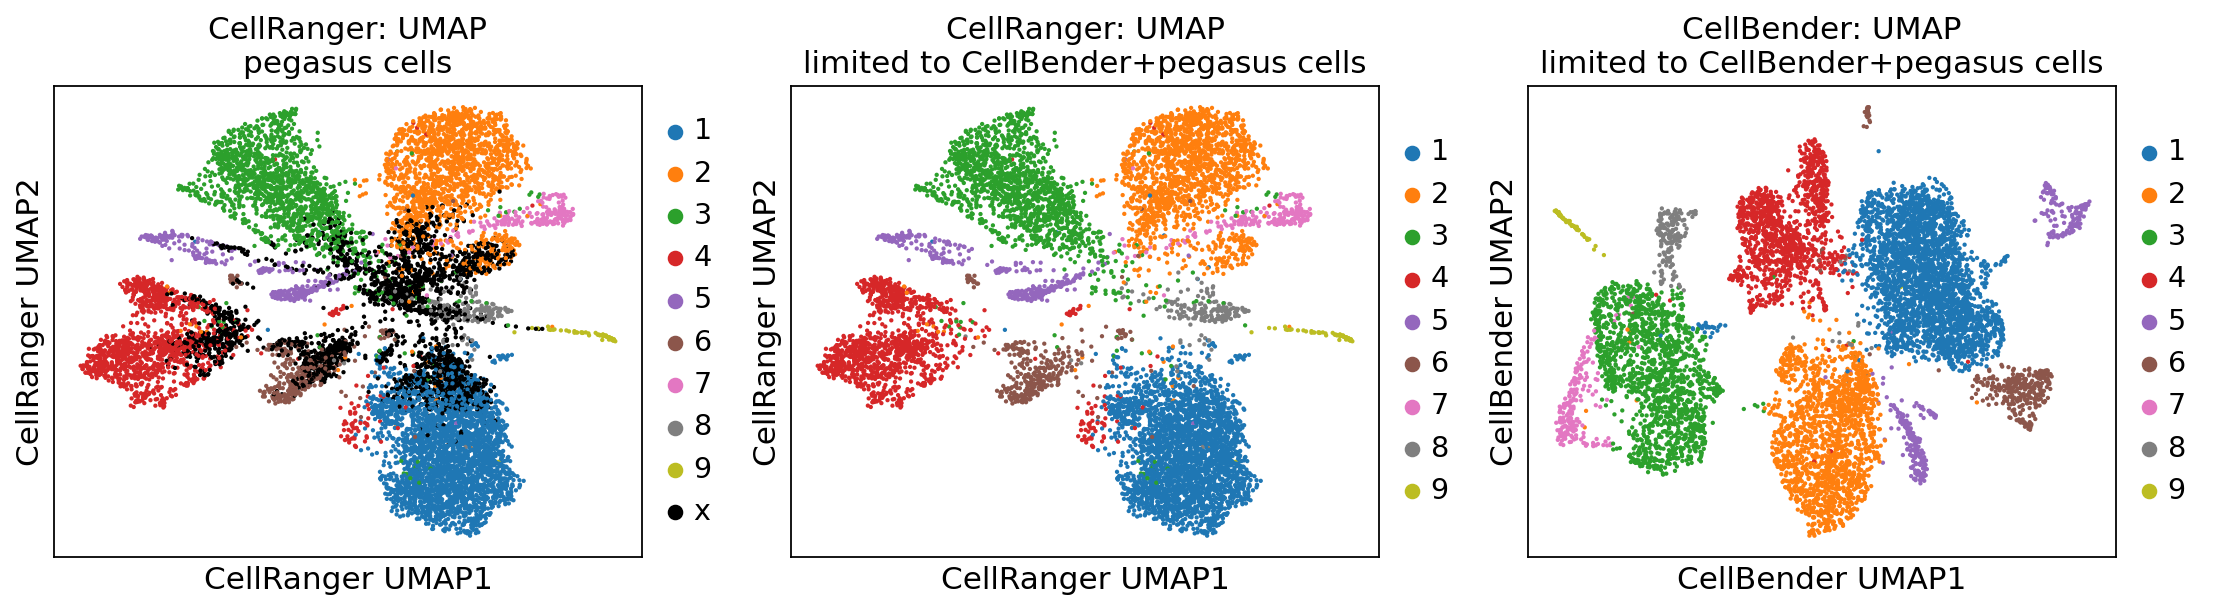

In [46]:
plt.rcParams.update({'font.size': 12})

cluster_key = 'leiden_labels'

fig = plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sc.pl.embedding(adata_pegasus_raw, basis='umap', color=cluster_key, 
                ax=plt.gca(), size=15, show=False, palette=adata.uns[cluster_key + '_colors'].tolist() + ['k'])
plt.title('CellRanger: UMAP\npegasus cells')
plt.xlabel('CellRanger UMAP1')
plt.ylabel('CellRanger UMAP2')

plt.subplot(1, 3, 2)
sc.pl.embedding(adata, basis='Raw_umap', color=cluster_key, 
                ax=plt.gca(), size=15, show=False)
plt.title('CellRanger: UMAP\nlimited to CellBender+pegasus cells')
plt.xlabel('CellRanger UMAP1')
plt.ylabel('CellRanger UMAP2')

plt.subplot(1, 3, 3)
sc.pl.embedding(adata, basis='umap', color=cluster_key, 
                ax=plt.gca(), size=15, show=False)
plt.title('CellBender: UMAP\nlimited to CellBender+pegasus cells')
plt.xlabel('CellBender UMAP1')
plt.ylabel('CellBender UMAP2')

plt.tight_layout()

fig.savefig('/home/jupyter-user/analysis/figures/cluster_umap_3.pdf', bbox_inches='tight')

plt.show()

In [47]:
set(adata.obs.index) - set(adata_pegasus_raw.obs.index)

set()

In [48]:
np.sum([bc not in adata_pegasus_raw.obs.index for bc in adata.obs.index])

0

## QC metrics of removed versus kept droplets

In [17]:
adata_pegasus_raw

AnnData object with n_obs × n_vars = 10687 × 26345
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'JerbyMelanoma_B_CELL', 'JerbyMelanoma_CAF', 'JerbyMelanoma_ENDOTHELIAL', 'JerbyMelanoma_MACROPHAGE', 'JerbyMelanoma_MALIGNANT', 'JerbyMelanoma_NK', 'JerbyMelanoma_T_CD4', 'JerbyMelanoma_T_CD8', 'JerbyMelanoma_T_CELL', 'JerbyMelanoma_STROMA', 'JerbyMelanoma_IMMUNE', 'JerbyMelanoma_T_CD4_EXHAUSTED', 'JerbyMelanoma_T_CD4_NAIVE', 'JerbyMelanoma_T_CD4_TREG', 'JerbyMelanoma_T_CD8_CYTOTOXIC', 'JerbyMelanoma_T_CD8_EXHAUSTED', 'JerbyMelanoma_T_CD8_NAIVE', 'HTAPP_epithelial', 'HTAPP_macrophage_nuc', 'HTAPP_tcell_nuc', 'HTAPP_bcell_nuc', 'HTAPP_mast_cell', 'HTAPP_fibrocyte', 'HTAPP_astrocytes', 'HTAPP_oligodendrocytes', 'HTAPP_microglia', 'HTAPP_skeletal_muscle_myocyte_nuc', 'HTAPP_melanoma_signature', 'HTAPP_melanocyte', 'HTAPP_hepatocyte', 'HTAPP_alveolar_rhabdomyosarcoma', 'HTAPP_Ewing_sarcoma', 'HTAPP_basal_cells', 'HTAPP_secretory_cells', 'HTAPP_ciliated_cells', 'HTAPP_gobl

In [18]:
adata

AnnData object with n_obs × n_vars = 8292 × 33567
    obs: 'sample', 'n_counts', 'n_genes', 'LungMuus_Basal', 'LungMuus_Secretory', 'LungMuus_Ciliated', 'LungMuus_Tuft.like', 'LungMuus_Ionocytes', 'LungMuus_AT1', 'LungMuus_AT2', 'LungMuus_Mesothelium', 'LungMuus_Endothelial', 'LungMuus_Fibroblast', 'LungMuus_Pericytes', 'LungMuus_SmoothMuscle', 'LungMuus_Myeloid', 'LungMuus_B.cells', 'LungMuus_Mast', 'LungMuus_T.NK.cells', 'LungMuus_immune', 'LungAtlasBraga_Basal', 'LungAtlasBraga_Ciliated', 'LungAtlasBraga_Club', 'LungAtlasBraga_Goblet1', 'LungAtlasBraga_Goblet2', 'LungAtlasBraga_Ionocyte', 'LungAtlasBraga_AT2', 'LungAtlasBraga_AT1', 'LungAtlasBraga_Macrophage', 'LungAtlasBraga_Dendritic_cells', 'LungAtlasBraga_Fibroblast', 'LungAtlasBraga_Smooth_muscle', 'leiden_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'X_umap'
    layers: 'cellranger', 'cellbender'

In [19]:
adata_empty = adata_pegasus_raw[[bc not in adata.obs.index for bc in adata_pegasus_raw.obs.index]]
adata_empty

/home/jupyter-user/.local/lib/python3.7/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['W_pca'] that happens to be dimensioned at n_obs×n_obs (10687×10687).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,


View of AnnData object with n_obs × n_vars = 2399 × 26345
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'JerbyMelanoma_B_CELL', 'JerbyMelanoma_CAF', 'JerbyMelanoma_ENDOTHELIAL', 'JerbyMelanoma_MACROPHAGE', 'JerbyMelanoma_MALIGNANT', 'JerbyMelanoma_NK', 'JerbyMelanoma_T_CD4', 'JerbyMelanoma_T_CD8', 'JerbyMelanoma_T_CELL', 'JerbyMelanoma_STROMA', 'JerbyMelanoma_IMMUNE', 'JerbyMelanoma_T_CD4_EXHAUSTED', 'JerbyMelanoma_T_CD4_NAIVE', 'JerbyMelanoma_T_CD4_TREG', 'JerbyMelanoma_T_CD8_CYTOTOXIC', 'JerbyMelanoma_T_CD8_EXHAUSTED', 'JerbyMelanoma_T_CD8_NAIVE', 'HTAPP_epithelial', 'HTAPP_macrophage_nuc', 'HTAPP_tcell_nuc', 'HTAPP_bcell_nuc', 'HTAPP_mast_cell', 'HTAPP_fibrocyte', 'HTAPP_astrocytes', 'HTAPP_oligodendrocytes', 'HTAPP_microglia', 'HTAPP_skeletal_muscle_myocyte_nuc', 'HTAPP_melanoma_signature', 'HTAPP_melanocyte', 'HTAPP_hepatocyte', 'HTAPP_alveolar_rhabdomyosarcoma', 'HTAPP_Ewing_sarcoma', 'HTAPP_basal_cells', 'HTAPP_secretory_cells', 'HTAPP_ciliated_cells', 'HTA

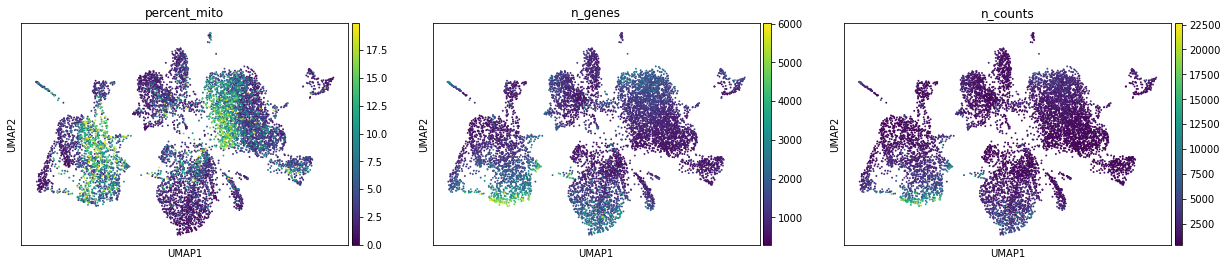

In [30]:
adata.obs['percent_mito'] = adata_pegasus_raw.obs['percent_mito'].copy()

sc.pl.embedding(adata, basis='umap', color=['percent_mito', 'n_genes', 'n_counts'])

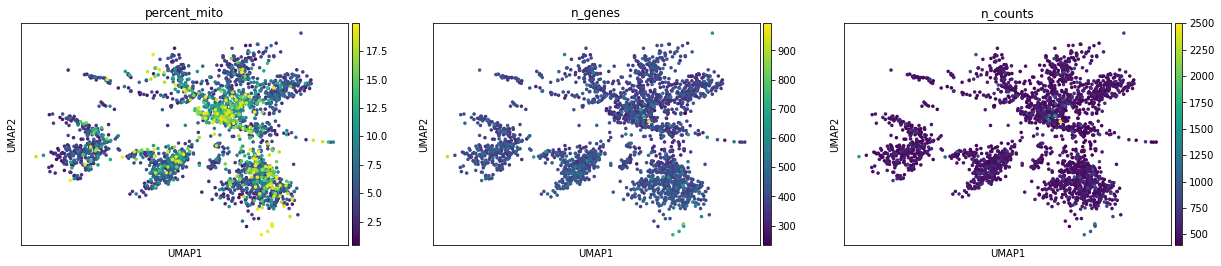

In [31]:
sc.pl.embedding(adata_empty, basis='umap', color=['percent_mito', 'n_genes', 'n_counts'])

/home/jupyter-user/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jupyter-user/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


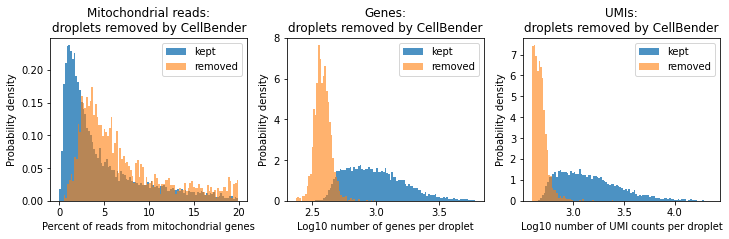

In [52]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.hist(adata.obs['percent_mito'].values, 
         bins=100, density=True, alpha=0.8, label='kept')
plt.hist(adata_empty.obs['percent_mito'].values, 
         bins=100, density=True, alpha=0.6, label='removed')
plt.title('Mitochondrial reads:\ndroplets removed by CellBender')
plt.xlabel('Percent of reads from mitochondrial genes')
plt.ylabel('Probability density')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(np.log10(adata.obs['n_genes'].values), 
         bins=100, density=True, alpha=0.8, label='kept')
plt.hist(np.log10(adata_empty.obs['n_genes'].values), 
         bins=50, density=True, alpha=0.6, label='removed')
plt.title('Genes:\ndroplets removed by CellBender')
plt.xlabel('Log10 number of genes per droplet')
plt.ylabel('Probability density')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(np.log10(adata.obs['n_counts'].values), 
         bins=100, density=True, alpha=0.8, label='kept')
plt.hist(np.log10(adata_empty.obs['n_counts'].values), 
         bins=50, density=True, alpha=0.6, label='removed')
plt.title('UMIs:\ndroplets removed by CellBender')
plt.xlabel('Log10 number of UMI counts per droplet')
plt.ylabel('Probability density')
plt.legend()

plt.gcf().savefig('/home/jupyter-user/analysis/figures/cellbender_removed_QCs.pdf', bbox_inches='tight')

plt.show()